In [1]:
import datetime
import functools
from imposm.parser import OSMParser
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import pyproj
import requests
import scipy as sp
import rtree
from scipy import signal
import shapely.geometry
%pylab inline

import data_munging

os.chdir(data_munging.src_dir)

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# simple class that handles the parsed OSM data.
class HighwayCounter(object):
    highways = 0

    def ways(self, ways):
        # callback method for ways
        for osmid, tags, refs in ways:
            if 'highway' in tags:
              self.highways += 1

class SegmentFinder(object):
    segments = []
    
    def ways(self, ways):
        # callback method for ways
        for osmid, tags, refs in ways:
            prev_ref = None
            for ref in refs:
                if prev_ref is not None:
                    self.segments.append((prev_ref, ref))
                prev_ref = ref

class CoordsFinder(object):
    
    coords_dict = dict()
    def coords(self, coords):
        for osmid, lon, lat in coords:
            self.coords_dict[osmid] = (lon, lat)

class NodeCoords(object):
    node_coords = dict()

    def nodes(self, nodes):
        # callback method for nodes
        for osmid, tags, coords in nodes:
            self.node_coords[osmid] = coords

# instantiate counter and parser and start parsing
all_segments = SegmentFinder()
some_coords = NodeCoords()
all_coords = CoordsFinder()
# p = OSMParser(concurrency=4,
#               nodes_callback=some_coords.nodes,
#               ways_callback=all_segments.ways)
p = OSMParser(concurrency=4,
              coords_callback=all_coords.coords,
              ways_callback=all_segments.ways)
# p.parse('../../osrm/osm_data/chicago_illinois.osm')
p.parse('../dat/chicago_illinois.osm.pbf')
# done

In [7]:
segments_idx = rtree.index.Index('../dat/chicago_illinois')

In [3]:
segments_idx = rtree.index.Index('../dat/chicago_illinois')
total_failures = 0
total_tries = 0
for unique_index, segment in enumerate(SegmentFinder.segments):
    total_tries += 1
    try:
        lon0, lat0 = all_coords.coords_dict[segment[0]]
        lon1, lat1 = all_coords.coords_dict[segment[1]]
        coord0 = data_munging.NAD83(lon0, lat0)
        coord1 = data_munging.NAD83(lon1, lat1)
        segments_idx.insert(id=unique_index, coordinates=data_munging.coords_to_bb(coord0, coord1),
                           obj={'segment_ids': segment,
                                'shapely_line': shapely.geometry.LineString([coord0, coord1]),
                                'lonlat': ((lon0, lat0), (lon1, lat1))})
    except:
        total_failures += 1

In [ ]:
segments_idx.insert(id=unique_index, coordinates=data_munging.coords_to_bb(coord0, coord1),
                   obj={'segment_ids': segment,
                        'shapely_line': shapely.geometry.LineString([coord0, coord1]),
                        'latlon': ((lat0, lon0), (lat1, lon1))})

In [11]:
rides, readings = data_munging.read_raw_data()

In [12]:
rides = rides.loc[rides['created_at'] < '2016-03-01', :]
readings = readings.loc[readings['created_at'] < '2016-03-01', :]

In [13]:
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

In [28]:
start_coords = readings[['start_lat', 'start_lon']]
end_coords = readings[['end_lat', 'end_lon']]

In [29]:
bb_areas = list()
bb_width = list()
bb_height = list()
bb_max = list()
for i, reading in readings.iterrows():
    the_bb = data_munging.reading_to_bb(reading)
    bb_area = data_munging.area_of_bb(the_bb)
    bb_areas.append(bb_area)
    bb_width.append(np.abs(reading.start_x - reading.end_x))
    bb_height.append(np.abs(reading.start_y- reading.end_y))    
    bb_max.append(np.max([bb_width[-1], bb_height[-1]]))
#     intx_segments = segments_idx.intersection()
#     while len(intx_segments) == 0:        

[]

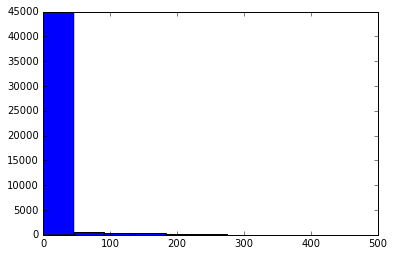

In [30]:
plt.hist(bb_areas)
plt.plot()

In [ ]:
plt.scatter(bb_width, bb_height)
plt.show()

In [ ]:
plt.hist(bb_max)
plt.show()

In [ ]:
n,p = readings.shape

In [ ]:
total_bb = pd.DataFrame(0, index=range(10), columns=[0.1, 0.4])

In [ ]:
total_bb = pd.DataFrame(0, index=range(n), columns=[0.5 ** x for x in range(10)])

In [37]:
expanded_bb

[357703.19461599627, 583273.5347882108, 357709.36077943386, 583284.5889752067]

In [42]:
segments_idx.bounds

[7.28e-321,
 6.3659873734e-314,
 -1.1167481221470064e+194,
 -1.0514157535291904e-277]

In [27]:
readings_to_osm_segments = dict()
for i, reading in readings.iterrows():
    the_bb = data_munging.reading_to_bb(reading)
    expanded_bb = data_munging.expand_bb(the_bb, 3.0)
    line_string = shapely.geometry.LineString([[reading.start_x, reading.start_y],
                                               [reading.end_x, reading.end_y]])
    closest_segment = None
    closest_dist = np.inf
    for segment in segments_idx.intersection(expanded_bb, objects=True):
        if segment.object['shapely_line'].distance(line_string) < closest_dist:
            closest_segment = segment.object['segment_ids']
    readings_to_osm_segments[reading.id] = closest_segment

In [31]:
readings_to_osm_segments[588]

(2207607827L, 2207607826L)

In [32]:
total_matches = 0
total_misses = 0
for key in readings_to_osm_segments:
    if readings_to_osm_segments[key] is None:
        total_misses += 1
    else:
        total_matches += 1

In [34]:
total_misses

31490

In [38]:
pkl.dumps(readings_to_osm_segments, open('readings_to_segments_chi.pkl', 'wb'))

In [24]:
reading['id']

588

In [ ]:
rtree.Rtree.

In [ ]:
for i in total_bb:
    for col in total_bb:
        the_bb = data_munging.reading_to_bb(readings.ix[i, :], 1)
        expand_bb = data_munging.expand_bb(readings.ix[i, :])
        total_bb[i, col] = len(segments_idx.intersection(data_munging.reading_to_bb(readings.ix[i,:])))

In [ ]:
print len(all_segments.segments)
print len(some_coords.node_coords)

In [ ]:
rides, readings = data_munging.read_raw_data()
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

In [ ]:
readings.columns

In [ ]:
readings.loc[0, ['num_accel_x', 'num_accel_y', 'num_accel_z', 'num_accel_total']]


In [ ]:
print rides.shape
print readings.shape
n, p = readings.shape

In [ ]:
nearest_request = 'http://127.0.0.1:5000/nearest?loc={0},{1}'
map_request = 'http://127.0.0.1:5000/match?loc={0},{1}&t={2}&loc={3},{4}&t={5}'

In [ ]:
map_request

In [ ]:
for snapped_var in ['snapped_' + var for var in ['start_lat', 'start_lon', 'end_lat', 'end_lon']]:
    readings[snapped_var] = 0

In [ ]:
osrm_response['matchings'][0]['matched_points']

In [ ]:
total_calls = 0
for i, reading in readings.iterrows():
    data = tuple(reading[['start_lat', 'start_lon']])+9
    print i
    print data 
    osrm_request = nearest_request.format(*data)
    osrm_response = requests.get(osrm_request).json()
    print osrm_response
    total_calls += 1
    if total_calls > 100:
        break

In [ ]:
total_calls = 0
for i, reading in readings.iterrows():
    data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
    print i
    print data 
    osrm_request = map_request.format(*data)
    osrm_response = requests.get(osrm_request).json()
    print osrm_response
    total_calls += 1
    if total_calls > 100:
        break

In [ ]:
for i, reading in readings.iterrows():
    data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
    osrm_request = map_request.format(*data)
    osrm_response = requests.get(osrm_request).json()
    print osrm_response
    readings.loc[i, ['snapped_start_lat', 'snapped_start_lon']] = osrm_response['matchings'][0]['matched_points'][0]
    break

In [ ]:
osrm_request = map_request.format(*reading[['start_lat', 'start_lon']], 0)


In [ ]:
(0, 4) + (0,5,9)

In [ ]:
# This does not work because OSRM does not accept floats as times. 
test_map_request = map_request.format(*tuple(a_reading[['start_lat', 'start_lon', 'start_time',
                                                'end_lat', 'end_lon', 'end_time']]))

In [ ]:
test_map_request = map_request.format(a_reading['start_lat'],
                                      a_reading['start_lon'], 
                                      0,
                                      a_reading['end_lat'],
                                      a_reading['end_lon'],
                                      1)

In [ ]:
print test_map_request
print requests.get(test_map_request).json()